In [ ]:
data = pd.read_csv('BO_Training_Dataset.csv')
data.drop(['sku'], axis = 1,inplace=True)

cat = data.select_dtypes(include = ['object']).columns
for col in cat:
    data[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    data[col] = data[col].astype(int)

data.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)
data.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)

In [7]:
df = data.drop(columns = ['forecast_3_month', 'forecast_6_month', 'forecast_9_month',
          'sales_3_month', 'sales_6_month', 'sales_9_month',
          'stop_auto_buy', 'perf_6_month_avg', 'perf_12_month_avg'], axis=1)

skewed_right = ['national_inv' , 'in_transit_qty' ,
                'pieces_past_due','local_bo_qty']

In [9]:
df_y = df['went_on_backorder']
X_train, X_test, y_train, y_test = train_test_split(df.drop(['went_on_backorder'], axis=1),
                                                    df_y , random_state = 42 , stratify=df_y,test_size=0.20)

In [10]:
log_columns = []

for i in skewed_right:
    log_columns.append(X_train.columns.get_loc(i))

In [11]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

In [12]:
def log_transform(a):
    sign = np.sign(a[log_columns])
    a[log_columns] =  np.log(1.0+abs(a[log_columns]))*sign
    return a

In [13]:
log_columns

[0, 2, 6, 7]

In [14]:
X_train_log = np.apply_along_axis(log_transform, 1, X_train)
X_test_log = np.apply_along_axis(log_transform, 1, X_test)

## **Base classifier**

In [15]:
# Fit a dummy classifier with strategy="uniform"
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_log, y_train)

DummyClassifier(strategy='uniform')

## **BRFC**

In [16]:
# Fit a BalancedBaggingClassifier
bb = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1).fit(X_train_log, y_train)

## **Fuzzy + BRFC**

In [18]:
import skfuzzy as fuzz

fuzzy_params = {
    'national_inv': [0, 10, 100],
    'lead_time': [0, 2, 10],
    'in_transit_qty': [0, 5, 100],
    'potential_issue': [0, 0.5, 1],
    'pieces_past_due': [0, 5, 50],
    'local_bo_qty': [0, 5, 50],
    'deck_risk': [0, 0.5, 1],
    'oe_constraint': [0, 0.5, 1],
    'ppap_risk': [0, 0.5, 1],
    'rev_stop': [0, 0.5, 1]
}

def apply_fuzzy_logic(data, fuzzy_params):
    fuzzy_inputs = []
    for i, (column, params) in enumerate(fuzzy_params.items()):
        fuzzy_membership = fuzz.trimf(data[:, i], params)
        fuzzy_inputs.append(fuzzy_membership)
    fuzzy_inputs_2D = [fuzzy_membership.reshape(-1, 1) for fuzzy_membership in fuzzy_inputs]
    return np.concatenate(fuzzy_inputs_2D, axis=1)

X_train_fuzzy = apply_fuzzy_logic(X_train_log, fuzzy_params)

bb_fuzzy = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1).fit(X_train_fuzzy, y_train)

In [24]:
X_test_fuzzy = apply_fuzzy_logic(X_test_log, fuzzy_params)

## **VAE + BRFC**

In [20]:
input_dim = X_train_log.shape[1]
latent_dim = 13

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

vae = Model(input_layer, decoded)

vae.compile(optimizer='adam', loss='mse')

vae.fit(X_train_log, X_train_log, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

encoder = Model(input_layer, encoded)
encoded_X_train = encoder.predict(X_train_log)

combined_X_train = np.concatenate([X_train_log, encoded_X_train], axis=1)

bb_autoencoder = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1).fit(combined_X_train, y_train)

Epoch 1/10
20972/20972 [==============================] - 58s 3ms/step - loss: 61823.2578 - val_loss: 21376.4023
Epoch 2/10
20972/20972 [==============================] - 54s 3ms/step - loss: 94610.9844 - val_loss: 1466.0571
Epoch 3/10
20972/20972 [==============================] - 53s 3ms/step - loss: 58130.9531 - val_loss: 3105.0144
Epoch 4/10
20972/20972 [==============================] - 53s 3ms/step - loss: 71227.7734 - val_loss: 40805.7578
Epoch 5/10
20972/20972 [==============================] - 53s 3ms/step - loss: 57369.9648 - val_loss: 53724.4766
Epoch 6/10
20972/20972 [==============================] - 51s 2ms/step - loss: 57247.8750 - val_loss: 13529.8916
Epoch 7/10
20972/20972 [==============================] - 53s 3ms/step - loss: 62572.8750 - val_loss: 3650.1560
Epoch 8/10
20972/20972 [==============================] - 50s 2ms/step - loss: 58998.3672 - val_loss: 1008.9648
Epoch 9/10
20972/20972 [==============================] - 48s 2ms/step - loss: 52971.6133 - val_loss

In [21]:
encoded_X_test = encoder.predict(X_test_log)
combined_X_test = np.concatenate([X_test_log, encoded_X_test], axis=1)

6554/6554 [==============================] - 10s 2ms/step


## **MLP**

In [22]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

mlp_model.fit(X_train_log, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20972/20972 [==============================] - 65s 3ms/step - loss: 0.0547 - accuracy: 0.9913 - val_loss: 0.0356 - val_accuracy: 0.9914
Epoch 2/10
20972/20972 [==============================] - 68s 3ms/step - loss: 0.0368 - accuracy: 0.9915 - val_loss: 0.0361 - val_accuracy: 0.9914
Epoch 3/10
20972/20972 [==============================] - 67s 3ms/step - loss: 0.0368 - accuracy: 0.9915 - val_loss: 0.0365 - val_accuracy: 0.9914
Epoch 4/10
20972/20972 [==============================] - 63s 3ms/step - loss: 0.0370 - accuracy: 0.9915 - val_loss: 0.0357 - val_accuracy: 0.9914
Epoch 5/10
20972/20972 [==============================] - 60s 3ms/step - loss: 0.0364 - accuracy: 0.9915 - val_loss: 0.0358 - val_accuracy: 0.9914
Epoch 6/10
20972/20972 [==============================] - 64s 3ms/step - loss: 0.0369 - accuracy: 0.9915 - val_loss: 0.0354 - val_accuracy: 0.9914
Epoch 7/10
20972/20972 [==============================] - 63s 3ms/step - loss: 0.0370 - accuracy: 0.9915 - val_loss: 0

In [25]:
dummy_preds_proba = dummy_clf.predict_proba(X_test_log)[:,1]
bb_preds_proba = bb.predict_proba(X_test_log)[:, 1]
bb_fuzzy_preds_proba = bb_fuzzy.predict_proba(X_test_fuzzy)[:, 1]
bb_autoencoder_preds_proba = bb_autoencoder.predict_proba(combined_X_test)[:, 1]
mlp_preds_proba = mlp_model.predict(X_test_log)

fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy_preds_proba)
fpr_bb, tpr_bb, _ = roc_curve(y_test, bb_preds_proba)
fpr_bb_fuzzy, tpr_bb_fuzzy, _ = roc_curve(y_test, bb_fuzzy_preds_proba)
fpr_bb_autoencoder, tpr_bb_autoencoder, _ = roc_curve(y_test, bb_autoencoder_preds_proba)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_preds_proba)

auc_dummy = auc(fpr_dummy, tpr_dummy)
auc_bb = auc(fpr_bb, tpr_bb)
auc_bb_fuzzy = auc(fpr_bb_fuzzy, tpr_bb_fuzzy)
auc_bb_autoencoder = auc(fpr_bb_autoencoder, tpr_bb_autoencoder)
auc_mlp = auc(fpr_mlp, tpr_mlp)

6554/6554 [==============================] - 12s 2ms/step


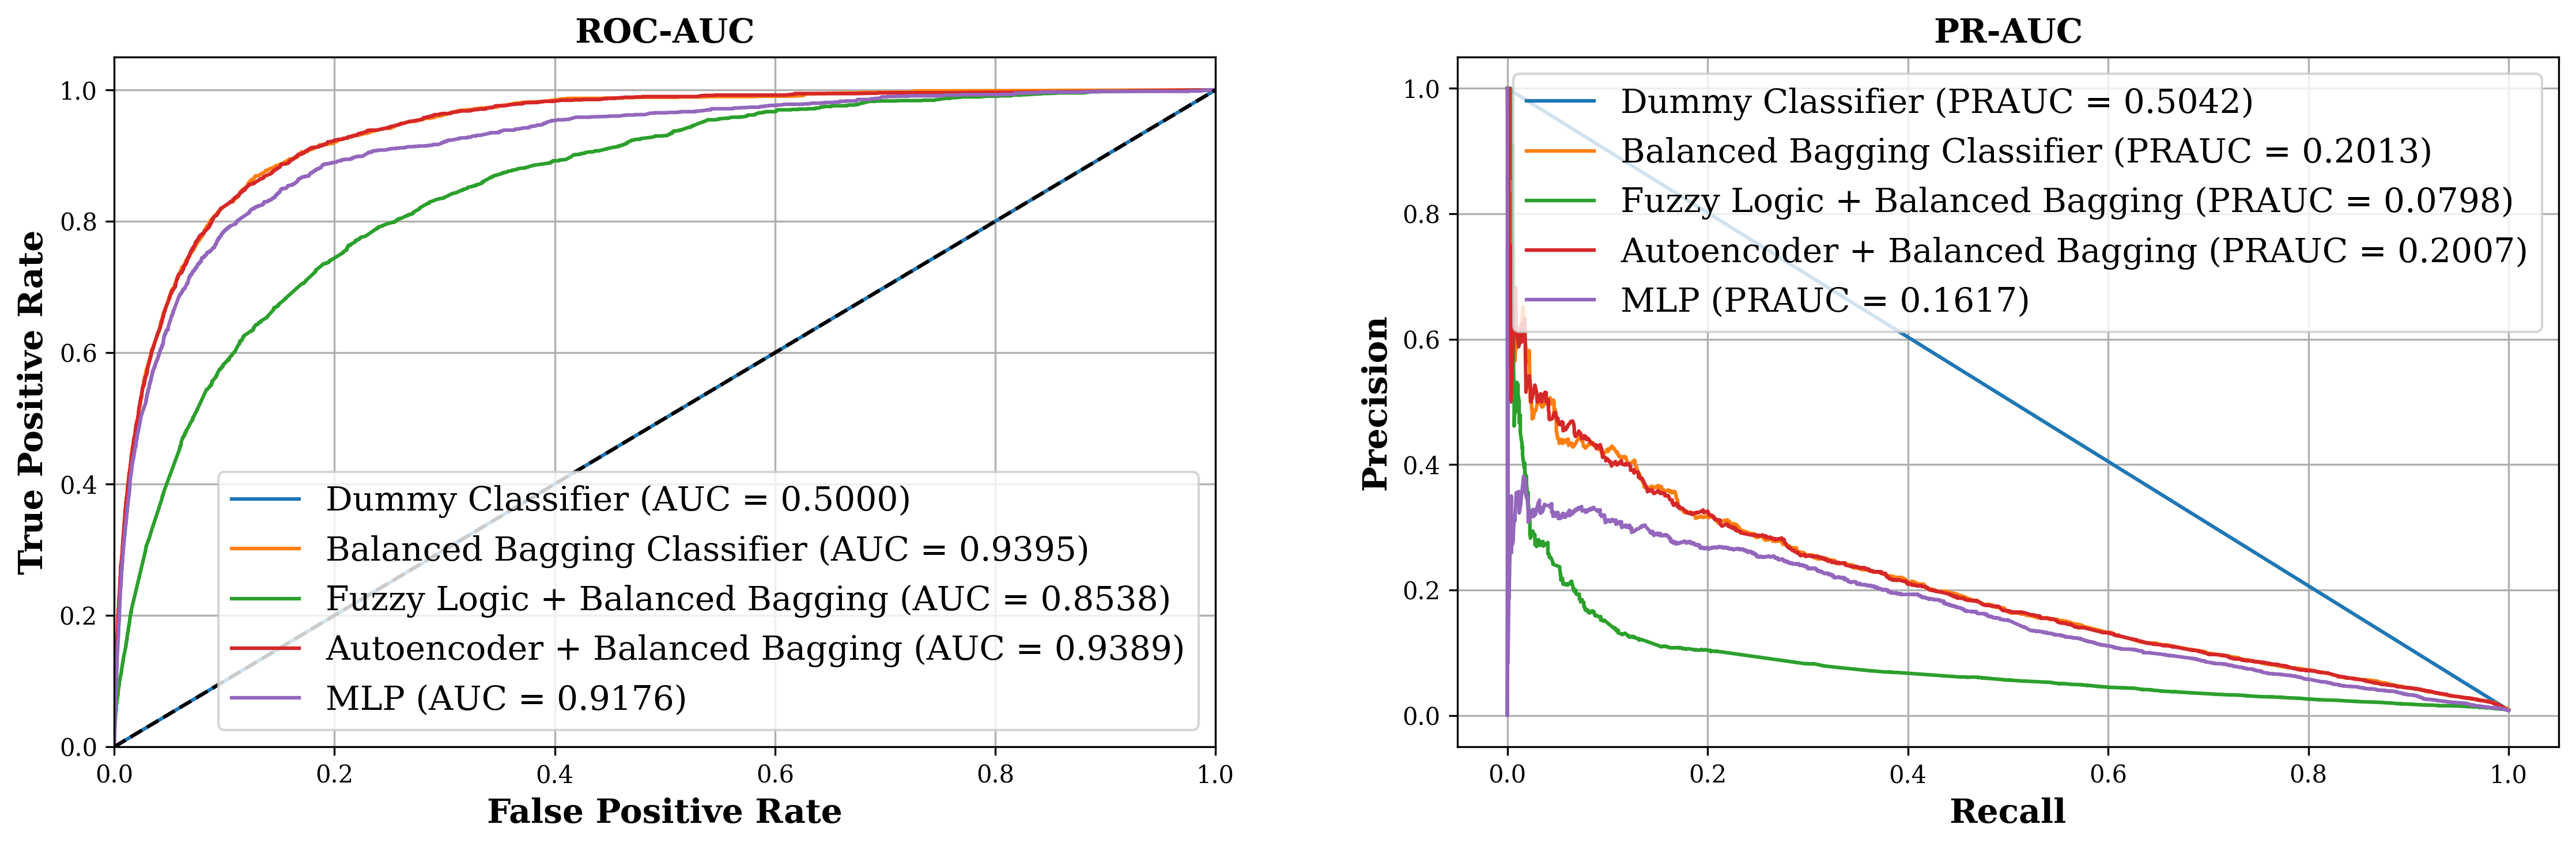

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
axes[0].plot(fpr_dummy, tpr_dummy, label=f'Dummy Classifier (AUC = {auc_dummy:.4f})')
axes[0].plot(fpr_bb, tpr_bb, label=f'Balanced Bagging Classifier (AUC = {auc_bb:.4f})')
axes[0].plot(fpr_bb_fuzzy, tpr_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (AUC = {auc_bb_fuzzy:.4f})')
axes[0].plot(fpr_bb_autoencoder, tpr_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (AUC = {auc_bb_autoencoder:.4f})')
axes[0].plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=14)
axes[0].set_title('ROC-AUC', fontsize=14, fontweight='bold')
axes[0].grid()

from sklearn.metrics import precision_recall_curve

preauc_dummy, recall_dummy, _ = precision_recall_curve(y_test, dummy_preds_proba)
auc_dummy = auc(recall_dummy, preauc_dummy)
preauc_bb, recall_bb, _ = precision_recall_curve(y_test, bb_preds_proba)
auc_bb = auc(recall_bb, preauc_bb)
preauc_bb_fuzzy, recall_bb_fuzzy, _ = precision_recall_curve(y_test, bb_fuzzy_preds_proba)
auc_fuzzy = auc(recall_bb_fuzzy, preauc_bb_fuzzy)
preauc_bb_autoencoder, recall_bb_autoencoder, _ = precision_recall_curve(y_test, bb_autoencoder_preds_proba)
auc_bbauto = auc(recall_bb_autoencoder, preauc_bb_autoencoder)
preauc_mlp, recall_mlp, _ = precision_recall_curve(y_test, mlp_preds_proba)
auc_mlp = auc(recall_mlp, preauc_mlp)

axes[1].plot(recall_dummy, preauc_dummy, label=f'Dummy Classifier (PRAUC = {auc_dummy:.4f})')
axes[1].plot(recall_bb, preauc_bb, label=f'Balanced Bagging Classifier (PRAUC = {auc_bb:.4f})')
axes[1].plot(recall_bb_fuzzy, preauc_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (PRAUC = {auc_fuzzy:.4f})')
axes[1].plot(recall_bb_autoencoder, preauc_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (PRAUC = {auc_bbauto:.4f})')
axes[1].plot(recall_mlp, preauc_mlp, label=f'MLP (PRAUC = {auc_mlp:.4f})')
axes[1].set_xlabel('Recall', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=14)
axes[1].set_title('PR-AUC', fontsize=14, fontweight='bold')
axes[1].grid()

plt.tight_layout()
plt.show()
